<div style="display: flex; align-items: center;">
    <img src="https://raw.githubusercontent.com/DanielPineresP/Parcial/main/logoun.png" alt="Logo Universidad" style="width: 100px; margin-right: 20px;">
    <div>
        <h1 style="font-family: consolas; font-size: 28px; font-weight: bold; margin: 0;">Proyecto de Grado: Análisis de sentimiento y clasificación de llamadas de centro de llamadas</h1>
        <p style="color: #949494; font-family: consolas; font-size: 20px; margin: 5px 0 0;">Daniel Piñeres Pesellin</p>
    </div>
</div>

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.0 <span style="color:blue">|</span> Librerias 
</h2> 
<a class="anchor" id="1.1"></a>

In [15]:
%%capture
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import tensorflow as tf
import xgboost as xgb

# ====================
# Librerías Generales
# ====================
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter

# ====================
# NLP y Preprocesamiento
# ====================
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from wordcloud import WordCloud
from textblob import TextBlob
import spacy

# Descargar recursos adicionales de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# ====================
# Manejo de Audio
# ====================
import wave
import contextlib
from pydub import AudioSegment
from IPython.display import display

# ==========================
# Machine Learning y Modelos
# ==========================
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize
from xgboost import XGBClassifier

# ====================
# Visualización Avanzada
# ====================
import plotly.express as px
import plotly.graph_objs as go

# ==========================
# Procesamiento y Modelos con Keras y TensorFlow
# ==========================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import AUC

# ==========================
# Procesamiento con Transformers
# ==========================
from transformers import (
    pipeline, DistilBertTokenizer, DistilBertForSequenceClassification,
    BertForSequenceClassification, BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification
)

# ====================
# Pytorch para Deep Learning
# ====================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset


<div style="text-align: left; font-size: 20px;">
    <table>
        <tr>
            <th><b>Website</b></th>
            <th><b>Links</b></th>
        </tr>
        <tr>
            <td>WhisperX</td>
            <td><a href="https://github.com/m-bain/whisperX"><img src="https://img.shields.io/badge/WhisperX-blue?style=for-the-badge&logo=whisperx" alt="WhisperX"/></a></td>
        </tr>
        <tr>
            <td>GloVe</td>
            <td><a href="https://nlp.stanford.edu/projects/glove/"><img src="https://img.shields.io/badge/GloVe-blue?style=for-the-badge&logo=glove" alt="GloVe"/></a></td>
        </tr>
        <tr>
            <td>Twitter RoBERTa Base Sentiment</td>
            <td><a href="https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment"><img src="https://img.shields.io/badge/Twitter%20RoBERTa%20Base%20Sentiment-blue?style=for-the-badge&logo=huggingface" alt="Twitter RoBERTa Base Sentiment"/></a></td>
        </tr>
    </table>
</div>


<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1 <span style="color:blue">|</span> EDA Dataset 
</h2> 
<a class="anchor" id="1.1"></a>

In [3]:
df =pd.read_csv(r"C:\Users\danie\OneDrive\Documentos\Tesis\conversation_with_sentiment_2.csv") ## esto lo debo borrar al final, no olvidar que es placeholder

In [3]:
df = pd.read_csv(r"C:\Users\danie\OneDrive\Documentos\Tesis\recordings_final.csv")

In [ ]:
df.head()

In [ ]:
df.info()

El data frame tiene un total de **xx** grabaciones, representadas por las columnas:
* **Filename** 
* **Conversation** 

Las transcripciones provienen de grabaciones de llamadas entre los agentes del centro de llamadas y clientes, escuchemos una y revisemos el desempeño de la transcripción resultado de `𝚆𝚑𝚒𝚜𝚙𝚎𝚛𝚇`.

In [ ]:
# Ruta completa del archivo .wav
wav_path = r"C:\Users\danie\OneDrive\Documentos\Tesis\calls\Recordings_WAV3\IB348869087-20241003-4406693831_AUTO-15030720.wav"

# Cargar y reproducir el archivo de audio
audio = AudioSegment.from_wav(wav_path)
display(audio)

In [ ]:
# Configurar pandas para mostrar texto largo sin truncar
pd.set_option('display.max_colwidth', None)

# Definir el nombre de archivo que queremos buscar
filename_to_find = "IB348869087-20241003-4406693831_AUTO-15030720.wav"

# Filtrar el DataFrame para encontrar la transcripción asociada al archivo especificado
selected_conversation = df[df['Filename'] == filename_to_find][['Filename', 'Conversation']]

# Mostrar la conversación en formato de tabla
selected_conversation

**Análisis de Unicidad de Transcripciones**

In [ ]:
print("Total sentences :",len(df))
print("Total unique sentences : ",df.Conversation.nunique())
print("Percentage of unique sentences ; ",df.Conversation.nunique()/len(df))

- **Total de transcripciones:** 3,593
- **Transcripciones únicas:** 3,296
- **Porcentaje de transcripciones únicas:** 91.73%

Esto significa que aproximadamente el 8.27% de las transcripciones están duplicadas, por lo tanto, se eliminarán las llamadas duplicadas, ya que no aportan valor.

In [ ]:
# Identificar duplicados y crear un DataFrame con ellos
duplicated_transcriptions = df[df.duplicated(subset=['Conversation'], keep=False)]
print(duplicated_transcriptions[['Filename', 'Conversation']].shape)  # Mostrar cantidad de duplicados encontrados

# Eliminar duplicados
df_unique = df.drop_duplicates(subset=['Conversation'])

# Mostrar resultados finales
print(f"Número de transcripciones removidas: {df.shape[0] - df_unique.shape[0]}")
print(f"Número de transcripciones únicas después de eliminar duplicados: {df_unique.shape[0]}")

**Construcción del Vocabulario de Palabras Únicas y Conteo de Frecuencia en Conversaciones**

In [ ]:
vocab = {}
for sen in tqdm(df.Conversation):
    for j in sen.split(" "):
        try:
            vocab[j] += 1
        except:
            vocab[j] = 1
print("Total words in vocabulary :", len(vocab))

En total hay 58,814 palabras en el vocabulario a partir de las 3,296 conversaciones.

In [ ]:
sorted_vocab = sorted(vocab.items(),key = lambda kv:kv[1],reverse=True)
sorted_vocab[:10]

Las mas recurrentes, `SPEAKER 0X:` están relacionadas con el hablante y no dicen mucho en este caso, posteriormente se hara limpieza de texto.

**Verificación de valores faltantes en el dataframe**

In [ ]:
print(f'data shape is: {df.shape}')
df.isnull().sum().sort_values(ascending = False)

No hay ningún faltante en el dataframe.

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.0 <span style="color:blue">|</span> Tiempo total de grabaciones (.wav) 
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
# Ruta de la carpeta principal
folder_path = r"C:\Users\danie\OneDrive\Documentos\Tesis\calls"

# Inicializar una variable para almacenar las duraciones
total_duration = 0

# Recorrer cada subcarpeta
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    # Verificar que sea una carpeta
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(subfolder_path, file)
                
                # Calcular la duración del archivo .wav y sumarla al total
                with contextlib.closing(wave.open(file_path, 'r')) as audio:
                    frames = audio.getnframes()
                    rate = audio.getframerate()
                    duration = frames / float(rate) / 60  # Convertir a minutos
                    total_duration += duration

# Convertir minutos a horas
total_hours = total_duration / 60

# Mostrar el tiempo total de todas las conversaciones en minutos y horas
if total_duration > 0:
    print(f"El tiempo total de todas las conversaciones es de: {total_duration:.2f} minutos")
    print(f"Equivalente a: {total_hours:.2f} horas")
else:
    print("No se encontraron archivos .wav en las carpetas especificadas.")

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.1 <span style="color:blue">|</span> Cálculo de Duraciones de Archivos de Audio (.wav) 
</h2> 
<a class="anchor" id="1.1"></a>

Este script recorre subcarpetas en una carpeta principal para localizar archivos de audio `.wav`, calcula su duración y obtiene métricas clave, incluyendo la duración máxima, mínima y promedio de los archivos encontrados.

In [ ]:
# Ruta de la carpeta principal
folder_path = r"C:\Users\danie\OneDrive\Documentos\Tesis\calls"

# Inicializar variables para almacenar duraciones
durations = []

# Recorrer cada subcarpeta
for subfolder in os.listdir(folder_path):
    subfolder_path = os.path.join(folder_path, subfolder)
    
    # Verificar que sea una carpeta
    if os.path.isdir(subfolder_path):
        for file in os.listdir(subfolder_path):
            if file.endswith(".wav"):
                file_path = os.path.join(subfolder_path, file)
                
                # Calcular la duración del archivo .wav
                with contextlib.closing(wave.open(file_path, 'r')) as audio:
                    frames = audio.getnframes()
                    rate = audio.getframerate()
                    duration = frames / float(rate) / 60  # Convertir a minutos
                    durations.append(duration)

# Calcular métricas
if durations:
    max_duration = max(durations)
    min_duration = min(durations)
    avg_duration = sum(durations) / len(durations)
    print(f"La duración máxima de una conversación es de: {max_duration:.2f} minutos")
    print(f"La duración mínima de una conversación es de: {min_duration:.2f} minutos")
    print(f"La duración promedio de las conversaciónes es de: {avg_duration:.2f} minutos")
else:
    print("No se encontraron archivos .wav en las carpetas especificadas.")


<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.2 <span style="color:blue">|</span> Cálculo de Métricas de Palabras en Transcripciones
</h2> 
<a class="anchor" id="1.1.2"></a>

Este script calcula la cantidad de palabras en cada transcripción dentro del DataFrame `df`, obteniendo métricas clave como el número máximo, mínimo y promedio de palabras en las transcripciones. Además, se visualiza la distribución de la longitud de transcripciones (en palabras) y se muestran estas métricas en un gráfico de barras.

In [ ]:
# Calcular la cantidad de palabras en cada transcripción
df['WordCount'] = df['Conversation'].apply(lambda x: len(x.split()))

# Calcular métricas de palabras
max_words = df['WordCount'].max()
min_words = df['WordCount'].min()
avg_words = df['WordCount'].mean()

# Crear la figura y los subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot 1: Histograma de longitud en palabras
axes[0].hist(df['WordCount'], bins=30, color='skyblue', edgecolor='black')
axes[0].set_title('Distribución de la longitud de transcripciones (en palabras)')
axes[0].set_xlabel('Número de palabras')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Subplot 2: Gráfico de Barras con métricas
metrics = ['Máximo', 'Mínimo', 'Promedio']
values = [max_words, min_words, avg_words]

bars = axes[1].bar(metrics, values, color=['blue', 'orange', 'green'])
axes[1].set_title('Métricas de longitud de transcripciones (en palabras)')
axes[1].set_ylabel('Número de palabras')

# Añadir etiquetas de datos sin decimales y con coma como separador de miles
for bar in bars:
    yval = int(bar.get_height())
    axes[1].text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:,}', ha='center', va='bottom')

# Ajustar espaciado entre los subplots
plt.tight_layout()
plt.show()



- **Dominio de transcripciones cortas:** La mayoría de las transcripciones tienen menos de 1000 palabras, indicando interacciones breves.
- **Distribución asimétrica:** La distribución tiene cola a la derecha, común en datos con muchas observaciones cortas y pocas largas.

- **Máximo (5,520 palabras):** Muestra que algunas transcripciones son significativamente largas, posiblemente conversaciones detalladas.
- **Mínimo (10 palabras):** Hay transcripciones muy cortas, probablemente saludos o interacciones breves.
- **Promedio (1,158 palabras):** La longitud promedio indica una tendencia hacia interacciones de longitud moderada, aunque la gran diferencia entre el máximo y el promedio sugiere diversidad en la duración de las grabaciones.-

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.3 <span style="color:blue">|</span> Limpieza de Texto y Generación de Nube de Palabras
</h2> 
<a class="anchor" id="1.1.3"></a>

Este script aplica una función de limpieza sobre el texto en la columna `Conversation` del DataFrame `df`, eliminando etiquetas de hablante, términos específicos, y caracteres especiales, y convirtiendo el texto a minúsculas. Posteriormente, se filtran las "stop words" para crear una lista de palabras relevantes, que luego se visualiza.

In [ ]:
# Función para limpiar el texto
def clean_text(text):
    # Eliminar "SPEAKER 0X:" con X siendo cualquier número
    text = re.sub(r'SPEAKER_\d+:', '', text)
    # Eliminar cualquier aparición de "direct energy" (en minúsculas para uniformidad)
    text = re.sub(r'\bdirect energy\b', '', text, flags=re.IGNORECASE)
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

# Crear una copia temporal de la columna 'Conversation' para no afectar el DataFrame original
df['TempCleanedConversation'] = df['Conversation'].apply(clean_text)

# Crear una lista de todas las palabras sin "stop words"
all_words = ' '.join(df['TempCleanedConversation']).split()
filtered_words = [word for word in all_words if word not in STOPWORDS]

# Crear la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(' '.join(filtered_words))

# Mostrar la nube de palabras
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Las palabras clave identificadas en las conversaciones, sin haber realizado limpieza, son: `okay`, `calling`, `account`, `thank`, `kilowatt hour`, entre otras. Esto tiene sentido, ya que se trata de un centro de llamadas donde se gestionan llamadas de servicio para empresas proveedoras de electricidad.]

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.4 <span style="color:blue">|</span> Limpieza de Texto y Análisis de N-gramas
</h2> 
<a class="anchor" id="1.1.4"></a>

Este script aplica una función de limpieza sobre el texto en la columna `Conversation` del DataFrame `df`, eliminando etiquetas de hablante, términos específicos y caracteres especiales, y convirtiendo el texto a minúsculas. A continuación, genera los **bigramas** y **trigramas** más comunes en las transcripciones usando `CountVectorizer`, y visualiza estos N-gramas en gráficos de barras para identificar patrones y frases frecuentes.

In [ ]:
# Función para limpiar el texto
def clean_text(text):
    # Eliminar "SPEAKER 0X:" con X siendo cualquier número
    text = re.sub(r'SPEAKER_\d+:', '', text)
    # Eliminar cualquier aparición de "direct energy" (en minúsculas para uniformidad)
    text = re.sub(r'\bdirect energy\b', '', text, flags=re.IGNORECASE)
    # Convertir a minúsculas y eliminar caracteres especiales
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    return text

# Crear una copia temporal de la columna 'Conversation' para no afectar el DataFrame original
df['TempCleanedConversation'] = df['Conversation'].apply(clean_text)

# Función para obtener los N-gramas más frecuentes
def get_top_ngrams(corpus, ngram_range=(2, 2), top_n=10):
    vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range)
    X = vectorizer.fit_transform(corpus)
    ngram_counts = X.sum(axis=0).A1
    ngram_words = vectorizer.get_feature_names_out()
    ngram_df = pd.DataFrame({'ngram': ngram_words, 'count': ngram_counts})
    top_ngrams = ngram_df.nlargest(top_n, 'count')
    return top_ngrams

# Obtener los bigramas y trigramas más comunes
top_bigrams = get_top_ngrams(df['TempCleanedConversation'], ngram_range=(2, 2), top_n=10)
top_trigrams = get_top_ngrams(df['TempCleanedConversation'], ngram_range=(3, 3), top_n=10)

# Crear subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Subplot de bigramas
axes[0].barh(top_bigrams['ngram'], top_bigrams['count'], color='skyblue')
axes[0].set_title('Bigramas más frecuentes')
axes[0].set_xlabel('Frecuencia')
axes[0].invert_yaxis()

# Subplot de trigramas
axes[1].barh(top_trigrams['ngram'], top_trigrams['count'], color='lightgreen')
axes[1].set_title('Trigramas más frecuentes')
axes[1].set_xlabel('Frecuencia')
axes[1].invert_yaxis()

# Ajustar espaciado entre subplots
plt.tight_layout()
plt.show()


Los gráficos de bigramas y trigramas muestran las combinaciones de palabras más comunes en las transcripciones.

- **Tópicos frecuentes**: Frases como `quality assurance` y `account number` indican temas recurrentes en las llamadas, como confirmaciones de identidad, tarifas y políticas de calidad.
- **Estructura y formalidad**: La presencia de frases formales y frases técnicas (`cents kilowatt hour`,`recorded quality assurance`) están relacionadas al de las llamadas, que son de atención al cliente y transacciones formales para pagos de facturas.


<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.5 <span style="color:blue">|</span> Cálculo y Visualización de la Diversidad Léxica
</h2> 
<a class="anchor" id="1.1.5"></a>

Este script calcula la **diversidad léxica** de cada transcripción en la columna `TempCleanedConversation` del DataFrame `df`, obteniendo la proporción de palabras únicas sobre el total de palabras en cada transcripción. La diversidad léxica se visualiza con un histograma para mostrar su distribución, y se calculan métricas adicionales como la diversidad máxima, mínima y promedio.

In [ ]:
# Función para calcular la diversidad léxica
def lexical_diversity(text):
    words = text.split()
    unique_words = set(words)
    if len(words) == 0:
        return 0  # Evitar división por cero en caso de transcripciones vacías
    return len(unique_words) / len(words)

# Crear una nueva columna para la diversidad léxica en el DataFrame
df['LexicalDiversity'] = df['TempCleanedConversation'].apply(lexical_diversity)

# Visualizar la diversidad léxica con un histograma
plt.figure(figsize=(10, 6))
plt.hist(df['LexicalDiversity'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Diversidad Léxica')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Diversidad Léxica en Transcripciones')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calcular métricas de diversidad léxica
max_diversity = df['LexicalDiversity'].max()
min_diversity = df['LexicalDiversity'].min()
avg_diversity = df['LexicalDiversity'].mean()

print(f"Diversidad léxica máxima: {max_diversity:.2f}")
print(f"Diversidad léxica mínima: {min_diversity:.2f}")
print(f"Diversidad léxica promedio: {avg_diversity:.2f}")


- **Diversidad léxica promedio (0.39)**: Indica que, en promedio, el 39% de las palabras en cada transcripción son únicas, mostrando una mezcla de repetición y variedad de vocabulario.
- **Diversidad léxica mínima (0.08)**: Algunas transcripciones tienen vocabulario muy repetitivo, común en interacciones cortas o centradas en temas específicos.
- **Diversidad léxica máxima (0.94)**: Hay transcripciones con un vocabulario muy variado, sin muchas repeticiones.

La mayoría de las transcripciones se encuentran entre 0.2 y 0.6, lo que sugiere que las conversaciones tienen repetición de vocabulario, pero con suficiente diversidad para cubrir distintos temas.


<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.6 <span style="color:blue">|</span> Detección de Temas Usando LDA
</h2> 
<a class="anchor" id="1.1.6"></a>

Este script utiliza el modelo **Latent Dirichlet Allocation (LDA)** para detectar temas principales en las transcripciones. Primero, aplica una limpieza de texto a la columna `Conversation`, eliminando términos específicos y caracteres especiales. Luego, realiza la **vectorización** de texto con `CountVectorizer` para construir una matriz de términos, y configura el modelo LDA para extraer cinco temas principales. Finalmente, se muestran las 10 palabras más representativas de cada tema identificado.

In [ ]:
# Función para limpiar el texto
def clean_text(text):
    text = re.sub(r'SPEAKER_\d+:', '', text)  # Eliminar "SPEAKER 0X:"
    text = re.sub(r'\bdirect energy\b', '', text, flags=re.IGNORECASE)  # Eliminar "direct energy"
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())  # Convertir a minúsculas y eliminar caracteres especiales
    return text

# Crear una copia temporal de la columna 'Conversation' y limpiar
df['TempCleanedConversation'] = df['Conversation'].apply(clean_text)

# Vectorización de texto
vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=10)  # min_df ajusta para omitir palabras raras
doc_term_matrix = vectorizer.fit_transform(df['TempCleanedConversation'])

# Configurar LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)  # Cambia n_components según la cantidad de temas que desees
lda.fit(doc_term_matrix)

# Función para mostrar los temas detectados
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Tema {idx + 1}:", end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# Mostrar los temas detectados con las 10 palabras más representativas
no_top_words = 10
display_topics(lda, vectorizer.get_feature_names_out(), no_top_words)


- **Tema 1:** Parece centrarse en consultas de cuentas y disponibilidad de planes, con palabras clave como `account`, `hold`, `plan`, y `available`.
- **Tema 2:** Contiene frases de interacción común y expresiones informales como `just`, `yeah`, `like`, y `dont`, indicando interacciones de confirmación o clarificación.
- **Tema 3:** Está orientado a detalles del servicio y de la cuenta, con palabras como `service`, `account`, `utility`, `address`, y `information`.
- **Tema 4:** Se relaciona con temas de electricidad y menciona palabras como `power` y `electric`, sugiriendo que este tema aborda cuestiones de suministro eléctrico.
- **Tema 5:** Enfocado en tarifas de gas, períodos y aspectos de facturación, con términos como `rate`, `gas`, y `months`.

Estos temas proporcionan una visión general de los tipos de consultas en las llamadas del centro de llamada, así como los temas de discusión frecuentes en el contexto del servicio de atención al cliente.

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.1.7 <span style="color:blue">|</span> Análisis de Longitud de Oraciones en Transcripciones
</h2> 
<a class="anchor" id="1.1.7"></a>

Este script calcula la longitud de cada oración en las transcripciones de la columna `TempCleanedConversation` del DataFrame `df`. Cada transcripción se divide en oraciones, y se mide el número de palabras en cada una. Luego, se visualiza la distribución de estas longitudes de oración mediante un histograma, y se calculan métricas clave como la longitud máxima, mínima y promedio de las oraciones.

In [ ]:
# Función para calcular la longitud de cada oración
def sentence_length_distribution(text):
    sentences = sent_tokenize(text)  # Dividir en oraciones
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]  # Longitud en palabras de cada oración
    return sentence_lengths

# Aplicar la función y guardar los resultados
df['SentenceLengths'] = df['TempCleanedConversation'].apply(sentence_length_distribution)

# Desplegar todas las longitudes en una lista plana para análisis
all_sentence_lengths = [length for lengths in df['SentenceLengths'] for length in lengths]

# Visualizar la distribución de la longitud de las oraciones
plt.figure(figsize=(10, 6))
plt.hist(all_sentence_lengths, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Longitud de la oración (número de palabras)')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Longitud de las Oraciones en Transcripciones')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Calcular métricas de longitud de oraciones
max_sentence_length = max(all_sentence_lengths)
min_sentence_length = min(all_sentence_lengths)
avg_sentence_length = sum(all_sentence_lengths) / len(all_sentence_lengths)

print(f"Longitud máxima de una oración: {max_sentence_length} palabras")
print(f"Longitud mínima de una oración: {min_sentence_length} palabras")
print(f"Longitud promedio de las oraciones: {avg_sentence_length:.2f} palabras")

- **Longitud máxima de una oración:** 4905 palabras. Hay oraciones extremadamente largas, posiblemente debido a concatenaciones de frases o fallos en la delimitación de oraciones durante la tokenización.
- **Longitud mínima de una oración:** 9 palabras. Esto indica que las oraciones más cortas tienen una cantidad mínima de palabras, probablemente preguntas o respuestas breves.
- **Longitud promedio de las oraciones:** 1000.11 palabras. Aunque es alta, esto puede deberse a las oraciones muy largas mencionadas anteriormente, que afectan el promedio.

- La mayoría de las oraciones se concentran entre 0 y 1000 palabras.

In [ ]:
df.columns

In [27]:
df.drop(columns=[ 'WordCount', 'TempCleanedConversation','LexicalDiversity', 'SentenceLengths'],axis=1,inplace=True)

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.2 <span style="color:blue">|</span> Analisis de sentimiento 
</h2> 
<a class="anchor" id="1.1"></a>

<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.2.1 <span style="color:blue">|</span> Breve preprocesamiento de texto 
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
# Function to preprocess and clean conversation text
def preprocess_text(text):
    # Ensure text is a string, if not, return an empty string
    if not isinstance(text, str):
        return ''
    
    # Remove speaker labels (e.g., SPEAKER_01:, SPEAKER_00:)
    text = re.sub(r'SPEAKER_\d+:\s+', '', text)
    
    # Remove standard greetings like "Hello, thank you for calling..."
    greetings = [
        r"Hello,? thank you for calling.*?",
        r"Thank you for calling.*?",
        r"How can I assist you today\??",
        r"Thank you so much for calling.*?",
        r"Thank you for your help.*?",
        r"Let me assist you.*?"
    ]
    
    # Remove standard greeting phrases
    for greeting in greetings:
        text = re.sub(greeting, '', text, flags=re.IGNORECASE)
    
    # Strip leading and trailing whitespace after cleaning
    return text.strip()

# Apply preprocessing to the 'Conversation' column
df['Conversation'] = df['Conversation'].apply(preprocess_text)

# Display the cleaned conversations
df.head(2)

<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.2.1 <span style="color:blue">|</span> Análisis de Sentimiento con BERT y Fragmentación para Conversaciones Largas
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
# Load the pre-trained BERT model for sentiment analysis
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# Function to process and classify each conversation with chunking
def classify_conversation(conversation):
    tokens = tokenizer.encode_plus(conversation, add_special_tokens=False, return_tensors='pt')

    # Split the input into chunks if it's too long (BERT's limit is 512 tokens)
    def get_input_ids_and_attention_mask_chunk():
        chunksize = 512
        input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
        attention_mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))

        for i in range(len(input_id_chunks)):
            input_id_chunks[i] = torch.cat([torch.tensor([101]), input_id_chunks[i], torch.tensor([102])])  # Add [CLS] and [SEP] tokens
            attention_mask_chunks[i] = torch.cat([torch.tensor([1]), attention_mask_chunks[i], torch.tensor([1])])  # Add attention masks for [CLS] and [SEP]

            pad_length = chunksize - input_id_chunks[i].shape[0]
            if pad_length > 0:
                input_id_chunks[i] = torch.cat([input_id_chunks[i], torch.Tensor([0] * pad_length)])  # Pad the input ids
                attention_mask_chunks[i] = torch.cat([attention_mask_chunks[i], torch.Tensor([0] * pad_length)])  # Pad the attention mask

        return input_id_chunks, attention_mask_chunks 

    input_id_chunks, attention_mask_chunks = get_input_ids_and_attention_mask_chunk()
    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(attention_mask_chunks)

    input_dict = {'input_ids': input_ids.long(), 'attention_mask': attention_mask.int()}

    # Get the output from the model
    outputs = model(**input_dict)
    probabilities = torch.nn.functional.softmax(outputs[0], dim=-1)

    # Average the probabilities over chunks
    mean_probabilities = probabilities.mean(dim=0)

    # Return the class with the highest probability
    return torch.argmax(mean_probabilities).item()

# Apply the function to each conversation in the 'Conversation' column
df['sentiment'] = df['Conversation'].apply(classify_conversation)

# Display the first few rows with the new sentiment column
df.head(2)

**Cantidad de transcripciones por categoría de sentimiento**

In [ ]:
sentiment_count = df["sentiment"].value_counts()

# Función para mostrar tanto el valor absoluto como el porcentaje
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return f"{absolute} ({pct:.1f}%)"

# Gráfico circular con leyenda y etiquetas descriptivas
plt.figure(figsize=(8, 6))
sentiment_count.plot(
    kind='pie', 
    autopct=lambda pct: func(pct, sentiment_count), 
    colors=['skyblue', 'lightgreen', 'salmon'], 
    startangle=90,
    labels=['Neutral', 'Positivo', 'Negativo']  # Etiquetas personalizadas
)

# Título y ajustes de la leyenda
plt.title("Distribución de transcripciones por categoría de Sentimientos")
plt.ylabel("")  # Remueve la etiqueta del eje Y para mejor apariencia
plt.legend(
    ["0 = Negativo", "1 = Neutral", "2 = Positivo"], 
    title="Sentimientos", 
    loc="center left", 
    bbox_to_anchor=(1, 0.5)  # Posiciona la leyenda fuera del gráfico
)

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [31]:
# Define the file path (esto se borra al final es placeholder)
file_path = r"C:\Users\danie\OneDrive\Documentos\Tesis\conversation_with_sentiment_2.csv"

# Export the DataFrame to CSV
df.to_csv(file_path, index=False, encoding='utf-8')

**Revisemos una transcripción categorizada como negativa**

In [ ]:
# Set pandas to display long text in full without truncation
pd.set_option('display.max_colwidth', None)

# Filter the DataFrame for rows where sentiment is classified as very negative (0)
very_negative_conversations = df[df['sentiment'] == 0]

# Display the first few very negative conversations for inspection
very_negative_conversations[['Conversation']].head(1)  # Adjust the number of rows as needed

Tiene sentido que se categorice esta llamada como negativa por las siguientes razones: 

- **Frustración y quejas**: La cliente  expresa frustración repetidamente sobre la falta de información que buscaba ("...this phone call was just a waste of time," "...we would have saved a lot of time").
  
- **Conflicto**: Hay una clara insatisfacción con el servicio proporcionado, especialmente al descubrir que la empresa no puede brindarle el desglose diario que necesita, lo que da lugar a respuestas repetitivas por parte del agente y la sensación de una comunicación ineficaz.
  
- **Tono de Descontento**: A lo largo de la conversación la clienta menciona varias veces que la factura no tiene sentido y que el servicio no cumple con sus expectativas, lo cual añade un tono negativo a la interacción.

**Preprocesamiento y Limpieza de Conversaciones**

In [4]:
# Function to preprocess and clean conversation text
def preprocess_text(text):
    # Ensure text is a string, if not, return an empty string
    if not isinstance(text, str):
        return ''
    
    # Remove speaker labels (e.g., SPEAKER_01:, SPEAKER_00:)
    text = re.sub(r'SPEAKER_\d+:\s+', '', text)
    
    # Remove standard greetings like "Hello, thank you for calling..."
    greetings = [
        r"Hello,? thank you for calling.*?",
        r"Thank you for calling.*?",
        r"How can I assist you today\??",
        r"Thank you so much for calling.*?",
        r"Thank you for your help.*?",
        r"Let me assist you.*?"
    ]
    
    # Remove standard greeting phrases
    for greeting in greetings:
        text = re.sub(greeting, '', text, flags=re.IGNORECASE)
    
    # Strip leading and trailing whitespace after cleaning
    return text.strip()

# Apply preprocessing to the 'Conversation' column
df['Conversation'] = df['Conversation'].apply(preprocess_text)

# Display the cleaned conversations
df.head(2)

,Filename,Conversation,sentiment
0,CXone recording_Daniel Acosta_2024-06-28_15-13...,"Power Next. This is Daniel, who you have the p...",1
1,CXone recording_Daniel Acosta_2024-07-01_13-18...,"Post Power. This is Daniel, who you'll have th...",0


In [5]:
# Asegúrate de descargar los recursos necesarios de NLTK
nltk.download('stopwords')
nltk.download('wordnet')

# Cargar el modelo de spaCy para lematización y NER
nlp = spacy.load("en_core_web_lg")

# Stop words personalizadas y caracteres adicionales
stop_words = set(stopwords.words('english')) | {'email', 'address', 'phone number', 'service', 'account'}
additional_stop_words = {'be', 'okay', 'i', 'you', 'that', 'not', 'it', 'we', 'my', 'in', 'to', 'the', '[ORG]', '[PERSON]', '[GPE]', '.', ',', '?', '-', ';', ':', '!', 'would'}

# Función para eliminar puntuación y números
def remove_punc_num(df, attribute):
    df.loc[:, attribute] = df[attribute].apply(lambda x: " ".join(re.findall(r'[\w]+', x)))
    df[attribute] = df[attribute].str.replace(r'\d+', '')
    return df

# 1. Eliminar stop words y palabras adicionales
def remove_stopwords(text):
    combined_stop_words = stop_words | additional_stop_words
    return ' '.join([word for word in text.split() if word.lower() not in combined_stop_words])

# 2. Lematización (usando spaCy)
def lemmatize_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# 3. Eliminar frases comunes
def remove_common_phrases(text):
    common_phrases = [
        r"thank you for calling", 
        r"how can i assist you today", 
        r"have a great day", 
        r"thank you for your patience"
    ]
    for phrase in common_phrases:
        text = re.sub(phrase, '', text, flags=re.IGNORECASE)
    return text.strip()

# 4. Eliminar stop words personalizadas (específicas de atención al cliente)
def remove_custom_stopwords(text):
    custom_stop_words = ['email', 'address', 'phone number', 'service', 'account']
    return ' '.join([word for word in text.split() if word.lower() not in custom_stop_words])

# 5. Omitir completamente entidades de nombres, organizaciones y ubicaciones
def mask_entities(text):
    doc = nlp(text)
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'GPE', 'ORG']:  # Enmascarar nombres, ubicaciones, organizaciones
            text = text.replace(ent.text, '')  # Eliminar el texto en lugar de reemplazarlo
    return text

# 6. Manejar negaciones
def handle_negations(text):
    negations = ["not", "never", "no"]
    words = text.split()
    for i, word in enumerate(words):
        if word in negations and i + 1 < len(words):
            words[i + 1] = "NOT_" + words[i + 1]  # Añadir marcador de negación a la palabra siguiente
    return ' '.join(words)

# 7. Eliminar palabras repetidas "yes", "ok", "right" etc.
def remove_repeated_words(text):
    # Reemplazar múltiples ocurrencias de "yes", "ok", "right", etc. con una sola instancia
    text = re.sub(r'\b(yes|ok|right|uh-huh|yeah|sure|mhm)\b(?:\s+\1)+', r'\1', text, flags=re.IGNORECASE)
    
    # Eliminar completamente estas palabras si no agregan valor
    frequent_words = ['yes', 'ok', 'right', 'uh-huh', 'yeah', 'sure', 'mhm']
    text = ' '.join([word for word in text.split() if word.lower() not in frequent_words])

    return text

# 8. Eliminar etiquetas de hablantes
def remove_speaker_labels(text):
    return re.sub(r'SPEAKER_\d+:\s+', '', text)

# Función completa de preprocesamiento que aplica todos los pasos
def preprocess_text(text):
    text = remove_speaker_labels(text)  # Eliminar etiquetas de hablantes primero
    text = remove_stopwords(text)  # Eliminar stop words
    text = lemmatize_text(text)  # Lematización
    text = remove_common_phrases(text)  # Eliminar frases comunes
    text = remove_custom_stopwords(text)  # Eliminar stop words personalizadas
    text = mask_entities(text)  # Enmascarar entidades
    text = handle_negations(text)  # Manejar negaciones
    text = remove_repeated_words(text)  # Eliminar palabras repetidas
    return text

# Aplicar la función de eliminar puntuación y números antes de los demás pasos de preprocesamiento
df = remove_punc_num(df, 'Conversation')

# Aplicar el preprocesamiento completo a la columna 'Conversation'
df['Conversation'] = df['Conversation'].apply(preprocess_text)

# Copiar el DataFrame final para verificar los cambios
df_no_punc = df.copy()

# Mostrar las primeras filas para revisar los resultados
df.head(3)

,Filename,Conversation,sentiment
0,CXone recording_Daniel Acosta_2024-06-28_15-13...,power pleasure speak sorry sir hear last name ...,1
1,CXone recording_Daniel Acosta_2024-07-01_13-18...,Daniel pleasure speak sorry hear please repeat...,0
2,CXone recording_Daniel Acosta_2024-07-01_15-45...,much go Daniel pleasure speak today Mr oh real...,1


**Frecuencia de palabras en cada categoría de sentimiento**

C:\Users\danie\AppData\Local\Temp\ipykernel_11352\3119564037.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


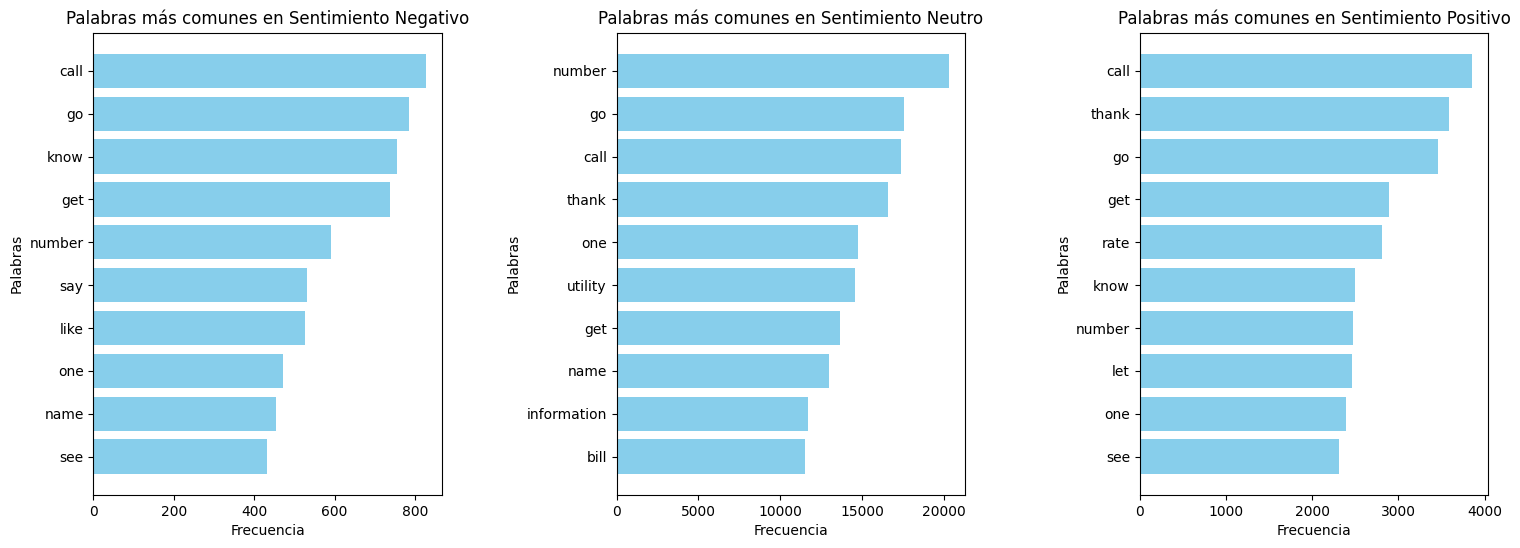

In [6]:
# Función para contar palabras en cada categoría de sentimiento
def get_top_words_by_sentiment(df, sentiment_label, num_words=10):
    # Filtrar las transcripciones de la categoría de sentimiento específica
    conversations = df[df['sentiment'] == sentiment_label]['Conversation']
    
    # Concatenar todas las conversaciones en una sola cadena de texto
    all_text = ' '.join(conversations)
    
    # Dividir en palabras y contar la frecuencia de cada una
    word_counts = Counter(all_text.split())
    
    # Seleccionar las palabras más comunes
    common_words = word_counts.most_common(num_words)
    
    # Convertir a un diccionario para facilitar la visualización
    return dict(common_words)

# Obtener las palabras más comunes en cada categoría de sentimiento
top_words_negative = get_top_words_by_sentiment(df, sentiment_label=0)
top_words_neutral = get_top_words_by_sentiment(df, sentiment_label=1)
top_words_positive = get_top_words_by_sentiment(df, sentiment_label=2)

# Configuración de los subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'wspace': 0.5})

# Función para graficar la frecuencia de palabras en un gráfico de barras
def plot_top_words(ax, top_words, sentiment_label):
    ax.barh(list(top_words.keys()), list(top_words.values()), color='skyblue')
    ax.set_xlabel('Frecuencia')
    ax.set_ylabel('Palabras')
    ax.set_title(f'Palabras más comunes en Sentimiento {sentiment_label}')
    ax.invert_yaxis()

# Graficar palabras más frecuentes en cada categoría de sentimiento en subplots
plot_top_words(axes[0], top_words_negative, "Negativo")
plot_top_words(axes[1], top_words_neutral, "Neutro")
plot_top_words(axes[2], top_words_positive, "Positivo")

plt.tight_layout()
plt.show()

**Distribución de Palabras Clave por Sentimiento**

C:\Users\danie\AppData\Local\Temp\ipykernel_11352\2544750325.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


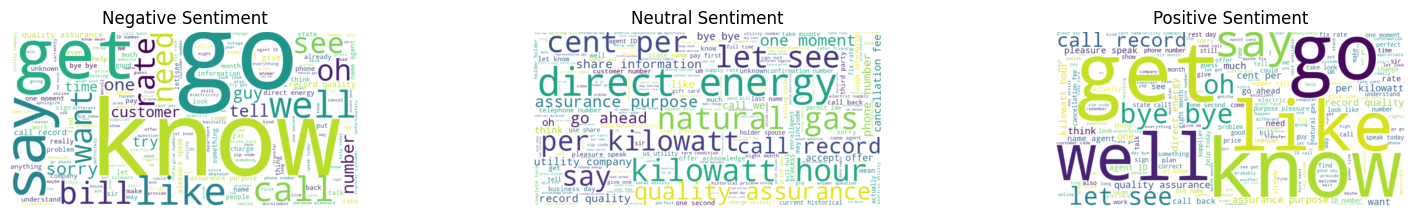

In [7]:
# Nube de palabras por categoría de sentimiento en subplots
additional_stop_words = ['yes', 'email', 'ms', 'mr', 'yeah', 'please', 'yall', 's', 'right', 'ok', 'okay', 'thanks', 'thank', 'Shell', 'Unknown:', 'iodine:', 'beryllium:', 'person:', 'Lashkar:', 'Taiba:']

def generate_wordcloud_filtered(sentiment_label, df, additional_stop_words):
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                          stopwords=set(additional_stop_words)).generate(
                          " ".join(df[df['sentiment'] == sentiment_label]['Conversation']))
    return wordcloud

# Crear subplots con espacio adicional
fig, axes = plt.subplots(1, 3, figsize=(18, 6), gridspec_kw={'wspace': 0.5})

# Generar y mostrar la nube de palabras para cada categoría de sentimiento en un subplot
sentiments = [0, 1, 2]
titles = ['Negative Sentiment', 'Neutral Sentiment', 'Positive Sentiment']

for i, sentiment in enumerate(sentiments):
    wordcloud = generate_wordcloud_filtered(sentiment, df, additional_stop_words)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(titles[i])

plt.tight_layout()
plt.show()

In [8]:
df.columns

Index(['Filename', 'Conversation', 'sentiment'], dtype='object')

In [9]:
df.drop(columns=['Filename'],axis=1,inplace=True)

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.3 <span style="color:blue">|</span> Entrenamiento modelos convencionales
</h2> 
<a class="anchor" id="1.1"></a>

Se evaluarán TF-IDF y GloVe para comparar su rendimiento en la clasificación multiclase. TF-IDF ofrece representaciones basadas en la frecuencia de términos, mientras que GloVe captura relaciones semánticas y contextuales entre palabras a partir de grandes corpus de texto. Esta comparación ayudará a identificar cuál técnica permite una mejor generalización y precisión en el modelo.

<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.3.1 <span style="color:blue">|</span> Vectorización de Textos con TF-IDF  
</h2> 
<a class="anchor" id="1.1"></a>

In [11]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df['Conversation'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [12]:
x_train, x_test, y_train, y_test = train_test_split(tfidf_df, df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42)

In [ ]:
# Ajuste de StratifiedKFold para reducir el número de particiones
stratified_kfold = StratifiedKFold(n_splits=3)
num_classes = df["sentiment"].nunique()

# Definición de modelos y parámetros expandidos
models = {
    "XGBoost": (xgb.XGBClassifier(eval_metric='mlogloss', num_class=num_classes), {
        'classifier__max_depth': [4, 6, 8],
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__gamma': [0, 0.1, 0.3],
        'classifier__subsample': [0.5, 0.7, 0.9],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__reg_alpha': [0, 0.1, 1],
        'classifier__reg_lambda': [1, 1.5, 2]
    }),

    "MLP": (MLPClassifier(max_iter=5000), {
        'classifier__hidden_layer_sizes': [(10,), (50,)],
        'classifier__alpha': [0.0001, 0.001],
        'classifier__learning_rate_init': [0.001, 0.01]
    }),
    "Random Forest": (RandomForestClassifier(), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5]
    }),
    "KNN": (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    })
}

results_df = pd.DataFrame()

for model_name, (model, params) in models.items():
    try:
        print(f"Training model: {model_name}")
        pipe = Pipeline([('classifier', model)])
        
        # Definir el GridSearchCV con f1_macro como métrica
        grid = GridSearchCV(pipe, param_grid=params, cv=stratified_kfold, n_jobs=-1, scoring='f1_macro')
        
        grid.fit(x_train, y_train)
        y_pred = grid.predict(x_test)
        y_prob = grid.predict_proba(x_test)

        # Calcular métricas
        precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='macro')

        # Cálculo de AUC (si hay más de una clase en y_test)
        if len(np.unique(y_test)) > 1:
            y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
            auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')
        else:
            auc = "Undefined (only one class in y_test)"
        
        # Agregar puntajes de entrenamiento y prueba
        train_score = grid.score(x_train, y_train)
        test_score = grid.score(x_test, y_test)
        
        # Guardar resultados sin imprimir Best Parameters
        result = {
            "Model": model_name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "AUC": auc,
            "Train Score": train_score,
            "Test Score": test_score,
            "Best Parameters": grid.best_params_ 
        }
        results_df = pd.concat([results_df, pd.DataFrame([result])], ignore_index=True)

    except Exception as e:
        print(f"Error occurred for {model_name}: {str(e)}")

Training model: XGBoost


In [ ]:
pd.set_option('display.max_colwidth', None)  # Esto asegura que el contenido completo de cada columna se muestre
pd.set_option('display.width', 1000)  # Ajusta el ancho de impresión según tu preferencia
pd.set_option('display.max_columns', None)  # Muestra todas las columnas del DataFrame

# Imprimir el DataFrame con todos los parámetros completos
print(results_df[['Model', 'Precision', 'Recall', 'F1-Score', 'AUC', 'Best Parameters', 'Test Set Score']])

<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.3.1.1 <span style="color:blue">|</span> Entrenamiento modelo con mejor resultado 
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
# Definir el modelo MLP con los mejores parámetros obtenidos
mlp_model = MLPClassifier(
    max_iter=5000,
    alpha=0.0001,
    hidden_layer_sizes=(10,),
    learning_rate_init=0.1
)

# DataFrame para almacenar los resultados
results_df2 = pd.DataFrame()

# Entrenar el modelo MLP
print("Training model: MLP")
mlp_model.fit(x_train, y_train)
y_pred = mlp_model.predict(x_test)
y_prob = mlp_model.predict_proba(x_test)

# Métricas
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
auc_score = roc_auc_score(label_binarize(y_test, classes=np.unique(y_train)), y_prob, multi_class='ovr')

# Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)

# Curva ROC
y_test_bin = label_binarize(y_test, classes=np.unique(y_train))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc_dict = {}

# Crear las figuras en subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico de Matriz de Confusión
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
ax1.set_title('Confusion Matrix for MLP')
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')

# Curvas ROC por clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])
    ax2.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (area = {roc_auc_dict[i]:.2f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve for MLP')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

# Calcular el micro-average de la curva ROC y su área
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc_micro = auc(fpr["micro"], tpr["micro"])

# Guardar los resultados
result = {
    "Model": "MLP",
    "Precision": precision,
    "Recall": recall,
    "F1-Score": f1,
    "AUC": roc_auc_micro
}
results_df2 = pd.concat([results_df2, pd.DataFrame([result])], ignore_index=True)

pd.set_option('display.max_colwidth', None)  # Esto asegura que el contenido completo de cada columna se muestre
pd.set_option('display.width', 1000)  # Ajusta el ancho de impresión según tu preferencia
pd.set_option('display.max_columns', None)  # Muestra todas las columnas del DataFrame

# Imprimir el DataFrame con todos los parámetros completos
print(results_df2[['Model', 'Precision', 'Recall', 'F1-Score', 'AUC']])


<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.3.2 <span style="color:blue">|</span> Generación de Embeddings Promedio con GloVe
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
# 1. Cargar los embeddings de GloVe
embeddings_index = {}
with open('C:\\Users\\danie\\Downloads\\glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# 2. Crear una función para transformar cada texto en su vector promedio de embeddings
def text_to_embedding(text, embeddings_index, embedding_dim=300):
    words = text.split()
    valid_embeddings = [embeddings_index[word] for word in words if word in embeddings_index]
    if not valid_embeddings:  # Si no hay embeddings válidos, retornar un vector de ceros
        return np.zeros(embedding_dim)
    return np.mean(valid_embeddings, axis=0)

# 3. Transformar el dataset completo
X_embedded = np.array([text_to_embedding(text, embeddings_index) for text in df['Conversation']])

# 4. Separar en entrenamiento y prueba usando los embeddings en lugar de TF-IDF
x_train, x_test, y_train, y_test = train_test_split(X_embedded, df['sentiment'], test_size=0.2, stratify=df['sentiment'], random_state=42)

In [ ]:
# Ajuste de StratifiedKFold para reducir el número de particiones
stratified_kfold = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)

# Definición de modelos y parámetros expandidos
models = {
    "XGBoost": (xgb.XGBClassifier(eval_metric='mlogloss', num_class=num_classes), {
        'classifier__max_depth': [4, 6, 8],
        'classifier__n_estimators': [100, 200, 300, 500],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        'classifier__gamma': [0, 0.1, 0.3],
        'classifier__subsample': [0.5, 0.7, 0.9],
        'classifier__colsample_bytree': [0.6, 0.8, 1.0],
        'classifier__min_child_weight': [1, 3, 5],
        'classifier__reg_alpha': [0, 0.1, 1],
        'classifier__reg_lambda': [1, 1.5, 2]
    }),
    "MLP": (MLPClassifier(max_iter=5000), {
        'classifier__hidden_layer_sizes': [(10,), (50,)],
        'classifier__alpha': [0.0001, 0.001],
        'classifier__learning_rate_init': [0.001, 0.01]
    }),
    "Random Forest": (RandomForestClassifier(), {
        'classifier__n_estimators': [100, 200],
        'classifier__max_depth': [10, 20],
        'classifier__min_samples_split': [2, 5]
    }),
    "KNN": (KNeighborsClassifier(), {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    })
}

results_df3 = pd.DataFrame()

for model_name, (model, params) in models.items():
    try:
        print(f"Training model: {model_name}")
        pipe = Pipeline([('classifier', model)])
        
        # Definir el GridSearchCV con f1_macro como métrica
        grid = GridSearchCV(pipe, param_grid=params, cv=stratified_kfold, n_jobs=-1, scoring='f1_macro')
        
        grid.fit(x_train, y_train)
        y_pred = grid.predict(x_test)
        y_prob = grid.predict_proba(x_test)

        # Calcular métricas
        precision = precision_score(y_test, y_pred, average='macro', zero_division=1)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=1)
        f1 = f1_score(y_test, y_pred, average='macro')

        # Cálculo de AUC (si hay más de una clase en y_test)
        if len(np.unique(y_test)) > 1:
            y_test_binarized = label_binarize(y_test, classes=np.unique(y_train))
            auc = roc_auc_score(y_test_binarized, y_prob, multi_class='ovr')
        else:
            auc = "Undefined (only one class in y_test)"
        
        # Agregar puntajes de entrenamiento y prueba
        train_score = grid.score(x_train, y_train)
        test_score = grid.score(x_test, y_test)
        
        # Guardar resultados sin imprimir Best Parameters
        result = {
            "Model": model_name,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1,
            "AUC": auc,
            "Train Score": train_score,
            "Test Score": test_score,
            "Best Parameters": grid.best_params_
        }
        results_df3 = pd.concat([results_df3, pd.DataFrame([result])], ignore_index=True)

    except Exception as e:
        print(f"Error occurred for {model_name}: {str(e)}")

In [ ]:
pd.set_option('display.max_colwidth', None)  # Esto asegura que el contenido completo de cada columna se muestre
pd.set_option('display.width', 1000)  # Ajusta el ancho de impresión según tu preferencia
pd.set_option('display.max_columns', None)  # Muestra todas las columnas del DataFrame

# Imprimir el DataFrame con todos los parámetros completos
print(results_df3[['Model', 'Precision', 'Recall', 'F1-Score', 'AUC', 'Best Parameters', 'Test Set Score']])

<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.4 <span style="color:blue">|</span> Entrenamiento con Redes Neuronales
</h2> 
<a class="anchor" id="1.1"></a>

<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.4.1 <span style="color:blue">|</span> Modelo LSTM para Clasificación Multiclase con Embeddings GloVe: Entrenamiento y Evaluación
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Configuración y variables globales
EMBEDDING_DIM = 300
MAX_LEN = 100  # Ajusta según el dataset
GLOVE_PATH = 'C:\\Users\\danie\\Downloads\\glove.6B.300d.txt'  # Ruta de GloVe
NUM_CLASSES = 3  # Cambia este valor al número total de clases

# 1. Tokenización de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Conversation'])
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) + 1

# 2. Convertir texto en secuencias y hacer padding
sequences = tokenizer.texts_to_sequences(df['Conversation'])
x_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 3. Dividir en conjuntos de entrenamiento y prueba
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.2, stratify=y, random_state=42)

# 4. Cargar embeddings de GloVe y crear la embedding_matrix
embeddings_index = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 5. Definir y compilar el modelo
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
    LSTM(100, dropout=0.3, recurrent_dropout=0.3),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')  # Softmax para multiclase
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Resumen del modelo
model.summary()

# 6. Configurar EarlyStopping y entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])


<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.4.2 <span style="color:blue">|</span> Evaluación de Desempeño del Modelo Bidirectional LSTM para Clasificación Multiclase de Sentimientos en Conversaciones
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
# 1. Tokenización de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Conversation'])
vocab_size = len(tokenizer.word_index) + 1

# 2. Convertir texto en secuencias y calcular longitud máxima basada en el percentil 90
all_sequences = tokenizer.texts_to_sequences(df['Conversation'])
sequence_lengths = [len(seq) for seq in all_sequences]
max_len = int(np.percentile(sequence_lengths, 90))  # Usar el percentil 90 para max_len

# 3. Padding de secuencias
x_sequences = pad_sequences(all_sequences, maxlen=max_len, padding='post', truncating='post')

# 4. Dividir en conjuntos de entrenamiento y prueba
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.2, stratify=y, random_state=42)

# 5. Cargar embeddings de GloVe y crear la embedding_matrix
embedding_dim = 300
embeddings_index = {}
with open('C:\\Users\\danie\\Downloads\\glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 6. Construir el modelo con Bidirectional LSTM para clasificación multiclase
model = Sequential()
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    weights=[embedding_matrix],
                    input_length=max_len,
                    trainable=False))
model.add(Bidirectional(LSTM(300, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))  # Cambiado a softmax para multiclase

# 7. Compilar el modelo
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.001), 
              metrics=['accuracy'])

# 8. Configuración de EarlyStopping para evitar sobreajuste
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 9. Entrenamiento del modelo
history = model.fit(x_train, y_train, 
                    epochs=5, 
                    batch_size=32, 
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping])

# 10. Graficar la curva de aprendizaje

plt.figure(figsize=(18, 5))

# Pérdida
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Precisión
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Ajuste gráfico
plt.tight_layout()
plt.show()

<h2 style="font-family: consolas; font-weight: bold; font-size: 18px;">
    1.4.3 <span style="color:blue">|</span> Clasificación Multiclase con CNN y GloVe: Entrenamiento, Evaluación de Métricas y Reporte de Desempeño por Clas
</h2> 
<a class="anchor" id="1.1"></a>

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Configuración y variables globales
EMBEDDING_DIM = 300
MAX_LEN = 100  # Ajusta según el dataset
GLOVE_PATH = 'C:\\Users\\danie\\Downloads\\glove.6B.300d.txt'  # Ruta de GloVe
NUM_CLASSES = 3  # Cambia este valor al número total de clases

# 1. Tokenización de texto
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['Conversation'])
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) + 1

# 2. Convertir texto en secuencias y hacer padding
sequences = tokenizer.texts_to_sequences(df['Conversation'])
x_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# 3. Dividir en conjuntos de entrenamiento y prueba
y = df['sentiment']
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.2, stratify=y, random_state=42)

# 4. Cargar embeddings de GloVe y crear la embedding_matrix
embeddings_index = {}
with open(GLOVE_PATH, 'r', encoding='utf-8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# 5. Definir y compilar el modelo CNN
model = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_LEN, trainable=False),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')  # Softmax para multiclase
])
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Resumen del modelo
model.summary()

# 6. Configurar EarlyStopping y entrenar el modelo
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stopping])

# 10. Graficar la curva de aprendizaje

plt.figure(figsize=(18, 5))

# Pérdida
plt.subplot(1, 2, 1)  # Cambiado a 1, 2 para dos subplots
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

# Ajuste gráfico
plt.tight_layout()
plt.show()


<h2 style="font-family: consolas; font-weight: bold; font-size: 20px;">
    1.5 <span style="color:blue">|</span> Conclusión
</h2> 
<a class="anchor" id="1.1"></a>